# Feature Engineering

I'm going to outline a strategy similar to the fast.ai machine learning course. The general plan is to 
1. Build a simple, decent random forset model
2. Use this to understand which features are most imporatnt, focus on improving and expanding upon these features
3. Step back with improved features and try a few other ensamble approaches to find the best
4. Tune hyperparamaters
5. Make predictions


## Basic Model

First, I'll make a basic RF model, then use this to test the effect of adding some additional datasets on top of our data. Loading in the data frame we left off with from last time.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix


style.use('fivethirtyeight')

In [2]:
interim_filepath = '../data/interim/'
data = pd.read_csv(f'{interim_filepath}sar_weather_df.csv')

First, though, I need a validation dataset. Since the goal is to predict into the future, we need to take this into account, like was discussed for the bulldozers dataset on Kaggle. I'll use the chronological end of my dataset for validation. If we take everything starting in 2017 and after, that will be ~15% of the total data.

Out test set will be real life - predicting the missions for this upcoming summer.

In [3]:
validate = data[data.Year > 2016]
train = data[data.Year <= 2016]

print(train.shape, validate.shape)

(5461, 35) (820, 35)


In [4]:
print(train.columns)

# remove the date for RF training
train.drop('DATE', axis=1, inplace=True)
validate.drop('DATE', axis=1, inplace=True)

Index(['mission', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'DATE', 'AWND_x', 'PRCP_x',
       'TAVG_x', 'TMAX_x', 'TMIN_x', 'TSUN', 'WT01', 'WT02', 'WT03', 'WT05',
       'WT08', 'WT10', 'AWND_y', 'PRCP_y', 'SNWD', 'TAVG_y', 'TMAX_y',
       'TMIN_y', 'TOBS', 'WESD'],
      dtype='object')


/anaconda3/envs/python3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
y_train = train['mission']
X_train = train.drop('mission', axis=1)

y_validate = validate['mission']
X_validate = validate.drop('mission', axis=1)

In [6]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print(m.score(X_train, y_train))
print(m.score(X_validate, y_validate))
print(m.oob_score_)

0.8659586156381615
0.6646341463414634
0.7216626991393518


**Unbalanced Classes**

The built-in scoring functions probably aren't ideal, since there's only a mission 29% of the time.

ROC curves are a decent approach for scoring our models. These weren't discussed in the fast.ai course, they focused mostly on regression problems. I found [this explination](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152) to be helpful. First, I'll calculate precision and recall and compare to a naive model that always predicts the major class (0).

In [7]:
y_score = [x[1] for x in m.predict_proba(X_validate)]

In [8]:
print(roc_auc_score(y_validate,y_score)) # my model
print(roc_auc_score(y_validate, 0.29*np.ones(len(y_validate)))) # naive model


0.6154291879795397
0.5


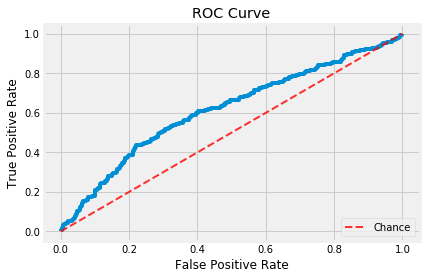

In [9]:
fpr, tpr, thresholds = roc_curve(y_validate, y_score)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

We aren't doing a super great job, but the model is pulling out some useful information beyone the naive model. What does the confusion matrix look like? Need to give the functions actual preductions, not probabilities.

Now, I'll write some functions for repeating these steps.

In [10]:
y_preds = m.predict(X_validate)
pd.crosstab(y_validate, y_preds, rownames=['True'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum())



Predicted,0,1
True,,
0,67.535854,49.056604
1,32.464146,50.943396


We're a little bit better at predicting negative days compared to positive ones.

In [11]:
## Automate the splitting, training and validation

def split_train_val(data):
    validate = data[data.Year > 2016]
    train = data[data.Year <= 2016]

    train.drop('DATE', axis=1, inplace=True)
    validate.drop('DATE', axis=1, inplace=True)
    
    y_train = train['mission']
    X_train = train.drop('mission', axis=1)

    y_validate = validate['mission']
    X_validate = validate.drop('mission', axis=1)
    
    return X_train, y_train, X_validate, y_validate


def build_RF(X_train, y_train):
    m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print('Training Score: ', m.score(X_train, y_train))
    print('OOB Score: ', m.oob_score_)
    return m
    
def test_RF(m, X_validate, y_validate):
    print('Validate Score: ',m.score(X_validate, y_validate))
    y_score = [x[1] for x in m.predict_proba(X_validate)]
    print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model
    fpr, tpr, thresholds = roc_curve(y_validate, y_score)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return True

                0           1
count  820.000000  820.000000
mean     0.663894    0.336106
std      0.099514    0.099514
min      0.343322    0.107622
25%      0.600024    0.260523
50%      0.676075    0.323925
75%      0.739477    0.399976
max      0.892378    0.656678


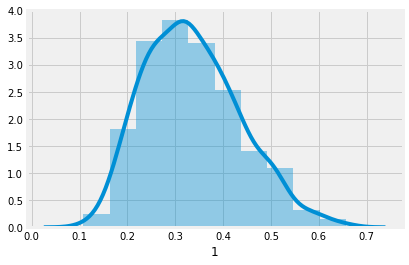

In [12]:
predictions = pd.DataFrame(m.predict_proba(X_validate))
sns.distplot(predictions[1], bins=10) #plot the prediction liklihood of a mission
print(predictions.describe())

Interesting. It's never more than 72% sure that a mission will happen. The negative predictive power is a bit better, getting as low as 11% liklihood. 

## Feature Importances

From what we have so far, what is driving our predictions?

In [13]:
def print_feat_imp(df, m):
    fi = pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
    print(fi)
    return fi

How can we improve our predictions? Add more features? Holidays? Google Data

## Adding additional features

Let's consider twp ypes of data that are avaliable to add.
- Holiday data
- Google Trends

### Holiday Data

Let's start with the US federal holidays and add them to the dataset as a bool. We also expect that the days surrounding a holiday may see an increase or decrease in missions as well. 

We'll use a list of holidays from pandas

In [14]:
import pandas.tseries.holiday as hol

us_cal = hol.USFederalHolidayCalendar()
dr = pd.date_range(start='2002-01-01', end='2019-05-01')
us_holidays = us_cal.holidays(start=dr.min(), end=dr.max())

In [15]:
# Add column holiday bool to data

data['holiday'] = 0
data['DATE'] =  pd.to_datetime(data['DATE'], infer_datetime_format=True,
                              format='datetime64[ns]')
data['holiday'] = data.DATE.isin(us_holidays)

# Insert the number of days before and after closest holiday

holiday = data.holiday
since = []
d = 0
for i in range(len(holiday)):
    d += 1
    if holiday[i]:
        d = 0   # if it's a holiday, reset
    since.append(d)
#data['holiday_days_since'] = since

before = []
d = 0
for i in range(len(holiday)):
    d += 1
    if holiday[len(holiday) - (i+1)]:
        d = 0   # if it's a holiday, reset
    before.append(d)
#data['holiday_days_before'] = before

data['holiday_closest'] = np.minimum(since, before)

/anaconda3/envs/python3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Score:  0.861380699505585
OOB Score:  0.7139718000366233
Validate Score:  0.6829268292682927
ROC AUC:  0.6509684036658141


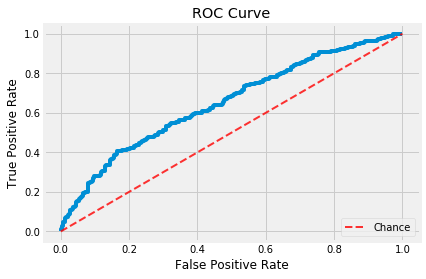

True

In [16]:
# Test it's effect on the model

X_train, y_train, X_validate, y_validate = split_train_val(data)
m = build_RF(X_train, y_train)
test_RF(m, X_validate, y_validate)

In [19]:
print_feat_imp(X_train, m)

                cols       imp
4          Dayofweek  0.084279
12           Elapsed  0.076172
5          Dayofyear  0.066932
13            AWND_x  0.063256
29            TMAX_y  0.060012
3                Day  0.059149
16            TMAX_x  0.058386
17            TMIN_x  0.057515
34   holiday_closest  0.055759
28            TAVG_y  0.051067
31              TOBS  0.050718
30            TMIN_y  0.049812
2               Week  0.041459
0               Year  0.039108
14            PRCP_x  0.035669
32              WESD  0.027994
26            PRCP_y  0.027571
27              SNWD  0.021089
1              Month  0.020041
15            TAVG_x  0.018279
25            AWND_y  0.018114
19              WT01  0.008423
23              WT08  0.003314
33           holiday  0.001864
7     Is_month_start  0.001178
6       Is_month_end  0.001041
20              WT02  0.000616
8     Is_quarter_end  0.000441
9   Is_quarter_start  0.000427
11     Is_year_start  0.000192
21              WT03  0.000079
10      

,cols,imp
4,Dayofweek,0.084279
12,Elapsed,0.076172
5,Dayofyear,0.066932
13,AWND_x,0.063256
29,TMAX_y,0.060012
3,Day,0.059149
16,TMAX_x,0.058386
17,TMIN_x,0.057515
34,holiday_closest,0.055759
28,TAVG_y,0.051067


After testing different approaches like 'days until next holiday', 'days since last holiday' and 'days from closest holiday', it looks like the 'closest holiday' column without the 'before' and 'since' give the strongest improvement. The is_holiday bool isn't very important on its own.

### Google Trends Data

My hypothesis is that google search trends could give us additional information by acting as a proxy for the number of people actually out on the hiking trails. We can actually get pretty specific data, and the information we're using here is focused on the general 'hiking' topic, however this topic is defined by Google. We can also zoom in on King County, which is where the vast majority of our calls occur.

The data itself was a little bit annoying to get. Google scales the frequency of data output based on how much data you look at. So for example, if I download the entire dataset

In [17]:
raw_filepath = '../data/raw/'

trends = pd.read_csv(f'{raw_filepath}/googletrends_hiking.csv', header=None, names=['date_t', 'trend'])

trends['date_t'] =  pd.to_datetime(trends['date_t'], infer_datetime_format=True,
                              format='datetime64[ns]')

data = pd.merge(data, trends, how='outer', left_on='DATE', right_on='date_t')

/anaconda3/envs/python3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


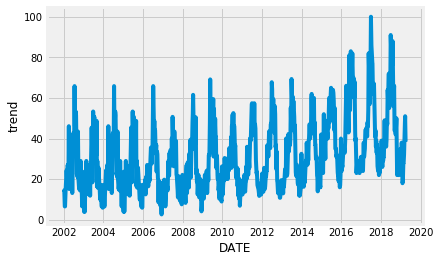

In [18]:
sns.lineplot(data.DATE, data.trend.interpolate())

This fits with my expectations, a seasaonal pattern of interest in hiking, with some variation week-to-week, which may capture information about other events happening in the area that draw people to or from the wilderness.

In [19]:
# Add data to the beginning and end of the dataset through interpolation
data['trend'] = data.trend.interpolate(limit_direction='both')

In [20]:
data.drop('date_t', axis=1, inplace=True)

/anaconda3/envs/python3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training Score:  0.8837209302325582
OOB Score:  0.7174510162973814
Validate Score:  0.675609756097561
ROC AUC:  0.6346307544757033


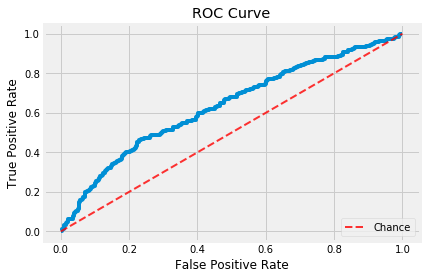

True

In [23]:
# Try a model with this additional data
X_train, y_train, X_validate, y_validate = split_train_val(data)
m = build_RF(X_train, y_train)
test_RF(m, X_validate, y_validate)

In [24]:
fi = print_feat_imp(X_train, m)

                cols       imp
4          Dayofweek  0.080800
35             trend  0.077419
12           Elapsed  0.072256
13            AWND_x  0.061275
16            TMAX_x  0.060764
5          Dayofyear  0.058113
3                Day  0.056477
29            TMAX_y  0.055301
17            TMIN_x  0.054456
34   holiday_closest  0.051362
31              TOBS  0.048617
28            TAVG_y  0.044573
30            TMIN_y  0.042719
2               Week  0.037376
0               Year  0.034482
14            PRCP_x  0.032454
26            PRCP_y  0.023866
32              WESD  0.023477
27              SNWD  0.018043
15            TAVG_x  0.017780
1              Month  0.017029
25            AWND_y  0.016170
19              WT01  0.006756
23              WT08  0.003728
33           holiday  0.001720
7     Is_month_start  0.000956
6       Is_month_end  0.000768
9   Is_quarter_start  0.000417
8     Is_quarter_end  0.000325
20              WT02  0.000294
11     Is_year_start  0.000125
21      

This is very puzzling to me. 'Trend' is clearly an important feature, but it doesn't improve the model by adding it in?

## Feature Importance - Digging In

In [26]:
# Save the data table for now.
data.to_csv(f'{interim_filepath}sar_weather_hol_trend.csv', index=False)

In [27]:
# Make a copy, add std, predictions
x = validate.copy()
x['pred_std'] = np.std(y_score, axis=0)
x['pred'] = y_score

In [28]:
# Predictions based on day of week

dow_summ = x[['Dayofweek', 'mission', 'pred', 'pred_std']].groupby('Dayofweek', as_index=False).mean()
dow_summ

,Dayofweek,mission,pred,pred_std
0,0,0.313559,0.311096,0.107018
1,1,0.230769,0.294994,0.107018
2,2,0.316239,0.293072,0.107018
3,3,0.256410,0.294412,0.107018
4,4,0.264957,0.286112,0.107018
5,5,0.551724,0.452425,0.107018
6,6,0.423729,0.455294,0.107018


/home/afederation/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


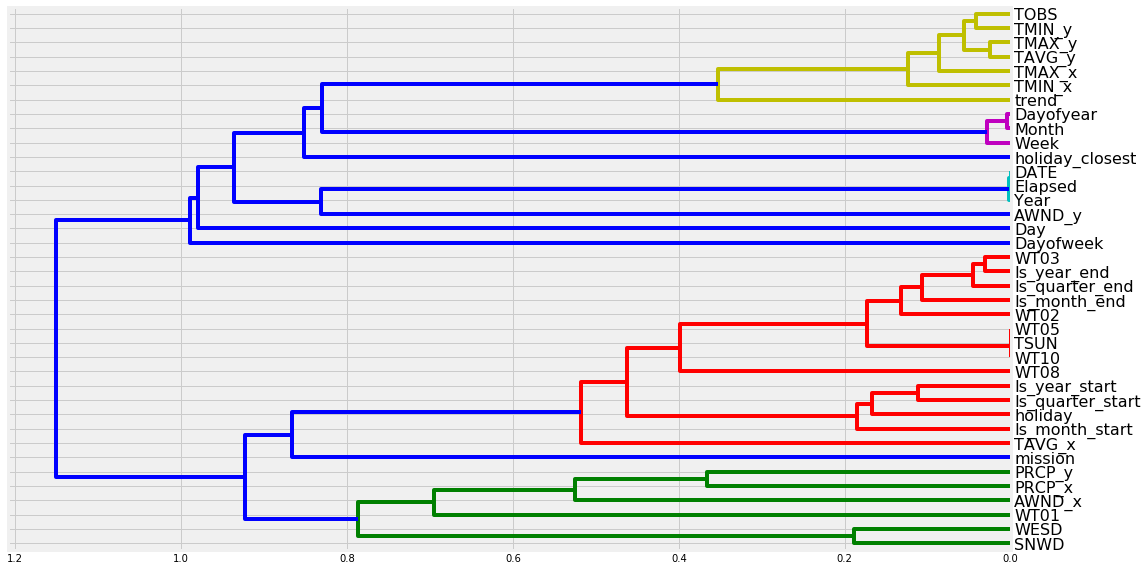

In [29]:
# Clustering Features
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(data).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=data.columns, orientation='left', leaf_font_size=16)
plt.show()

In [30]:
# Try removing the least important variables

# First with the baseline model
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print('Validate Score: ',m.score(X_validate, y_validate))
y_score = [x[1] for x in m.predict_proba(X_validate)]
print('ROC AUC: ', roc_auc_score(y_validate,y_score)) 
fpr, tpr, thresholds = roc_curve(y_validate, y_score)

# Then removing each feature
least_imp = fi[fi.imp < 0.01].cols
for c in least_imp:
    print(c,)
    m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
    m.fit(X_train.drop(c, axis=1), y_train)
    print('Validate Score: ',m.score(X_validate.drop(c, axis=1), y_validate))
    y_score = [x[1] for x in m.predict_proba(X_validate.drop(c, axis=1))]
    print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model
    fpr, tpr, thresholds = roc_curve(y_validate, y_score)

Validate Score:  0.6695121951219513
ROC AUC:  0.6366821184995739
WT01
Validate Score:  0.675609756097561
ROC AUC:  0.631900042625746
WT08
Validate Score:  0.6817073170731708
ROC AUC:  0.6383138853367434
Is_month_start
Validate Score:  0.675609756097561
ROC AUC:  0.6289828431372548
holiday
Validate Score:  0.6707317073170732
ROC AUC:  0.6394994138959931
Is_month_end
Validate Score:  0.6780487804878049
ROC AUC:  0.634197836743393
WT02
Validate Score:  0.6731707317073171
ROC AUC:  0.6252530903665815
Is_quarter_start
Validate Score:  0.6743902439024391
ROC AUC:  0.6260656436487638
Is_quarter_end
Validate Score:  0.6829268292682927
ROC AUC:  0.6437353473998295
Is_year_start
Validate Score:  0.6829268292682927
ROC AUC:  0.6234414961636828
Is_year_end
Validate Score:  0.6682926829268293
ROC AUC:  0.6203910912190963
WT03
Validate Score:  0.675609756097561
ROC AUC:  0.6395726768968457
WT05
Validate Score:  0.6695121951219513
ROC AUC:  0.6370351129582267
WT10
Validate Score:  0.6743902439024391


In [31]:
to_remove =['WT08', 'Is_month_start', 'WT02', 'Is_quarter_start', 'WT05', 'TSUN']
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train.drop(to_remove, axis=1), y_train)
print('Validate Score: ',m.score(X_validate.drop(to_remove, axis=1), y_validate))
y_score = [x[1] for x in m.predict_proba(X_validate.drop(to_remove, axis=1))]
print('ROC AUC: ', roc_auc_score(y_validate,y_score)) # my model
fpr, tpr, thresholds = roc_curve(y_validate, y_score)

Validate Score:  0.6841463414634147
ROC AUC:  0.6365955349531116


In [33]:
# Save the data table for now.
data.drop(to_remove, axis=1, inplace=True)
data.to_csv(f'{interim_filepath}sar_final.csv', index=False)

KeyError: "['WT08' 'Is_month_start' 'WT02' 'Is_quarter_start' 'WT05' 'TSUN'] not found in axis"

In [34]:
data

,mission,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_quarter_end,Is_year_end,...,PRCP_y,SNWD,TAVG_y,TMAX_y,TMIN_y,TOBS,WESD,holiday,holiday_closest,trend
0,1.0,2002.0,1.0,1.0,1.0,1.0,1.0,False,False,False,...,0.0,0.0,32.0,34.0,30.0,33.0,11.6,True,0.0,13.826509
1,0.0,2002.0,1.0,1.0,2.0,2.0,2.0,False,False,False,...,0.4,0.0,33.0,35.0,30.0,30.0,11.0,False,1.0,13.826509
2,1.0,2002.0,1.0,1.0,3.0,3.0,3.0,False,False,False,...,0.2,0.0,33.0,36.0,30.0,34.0,11.2,False,2.0,13.826509
3,0.0,2002.0,1.0,1.0,4.0,4.0,4.0,False,False,False,...,0.1,0.0,33.0,36.0,31.0,32.0,11.2,False,3.0,13.826509
4,1.0,2002.0,1.0,1.0,5.0,5.0,5.0,False,False,False,...,0.2,0.0,33.0,35.0,32.0,33.0,11.5,False,4.0,13.826509
5,1.0,2002.0,1.0,1.0,6.0,6.0,6.0,False,False,False,...,1.9,0.0,35.0,42.0,31.0,42.0,12.0,False,5.0,13.826509
6,0.0,2002.0,1.0,2.0,7.0,0.0,7.0,False,False,False,...,2.6,0.0,41.0,44.0,38.0,40.0,11.3,False,6.0,13.920567
7,0.0,2002.0,1.0,2.0,8.0,1.0,8.0,False,False,False,...,0.9,0.0,38.0,40.0,35.0,36.0,10.4,False,7.0,14.014624
8,0.0,2002.0,1.0,2.0,9.0,2.0,9.0,False,False,False,...,0.1,0.0,35.0,39.0,33.0,33.0,10.1,False,8.0,14.108682
9,0.0,2002.0,1.0,2.0,10.0,3.0,10.0,False,False,False,...,0.0,0.0,35.0,38.0,33.0,37.0,10.0,False,9.0,14.202740
